## Importing different packages

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
import pandas as pd
import numpy as np
import os
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import data, color
from google.colab import auth
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import layers, models, Input
import cv2
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img

### loading data from google drive

In [ ]:
drive.mount('/content/drive', force_remount=True)
#list_sub_dir = os.listdir('/content/drive/MyDrive/ArASL_Database_54K/')

Mounted at /content/drive


In [ ]:
! pip install kaggle

In [ ]:
#insert kaggle json file 
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"laylaibrahim12","key":"fcec8d4736ace935289796d5fcf42805"}'}

In [ ]:
#make directory kaggle 
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d zssash/zarasl-database-54k

 94% 61.0M/65.1M [00:00<00:00, 80.9MB/s]
100% 65.1M/65.1M [00:00<00:00, 111MB/s] 


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('zarasl-database-54k.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [ ]:
!ls files

ArASL_Database_54K  ImagesToPred  Labels


In [ ]:
list_sub_dir = os.listdir('/content/files/ArASL_Database_54K')

In [ ]:
def scale(image, label):
    return image/255., label

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory
PATH = '/content/files/ArASL_Database_54K'
nx = 128
ny = 128
train_dataset = image_dataset_from_directory(PATH,shuffle=True,color_mode="rgb",label_mode='categorical',validation_split=0.3,batch_size=64,labels='inferred',image_size=(nx,ny),subset="training",seed=123)
class_name = train_dataset.class_names
class_name
train_dataset = train_dataset.map(scale)
val_dataset = image_dataset_from_directory(PATH,shuffle=True,color_mode="rgb",label_mode='categorical',validation_split=0.3,batch_size=16,labels='inferred',image_size=(nx,ny),subset="validation",seed=123)
val_dataset = val_dataset.map(scale)

Found 54049 files belonging to 32 classes.
Using 37835 files for training.
Found 54049 files belonging to 32 classes.
Using 16214 files for validation.


In [ ]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(nx,ny,3))
base_model.trainable = False
base_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [ ]:
flatten_layer = layers.Flatten()
dense_layer1 = layers.Dense(500, activation='relu')
dense_layer2 = layers.Dense(250, activation='relu')
dense_layer3 = layers.Dense(125, activation='relu')
prediction_layer = layers.Dense(32, activation='softmax')
model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer1,
    dense_layer2,
    dense_layer3,
    prediction_layer
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 500)               4096500   
                                                                 
 dense_1 (Dense)             (None, 250)               125250    
                                                                 
 dense_2 (Dense)             (None, 125)               31375     
                                                                 
 dense_3 (Dense)             (None, 32)                4032      
                                                                 
Total params: 18,971,845
Trainable params: 4,257,157
Non

In [ ]:
from tensorflow.keras import optimizers
opt = optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 500)               4096500   
                                                                 
 dense_1 (Dense)             (None, 250)               125250    
                                                                 
 dense_2 (Dense)             (None, 125)               31375     
                                                                 
 dense_3 (Dense)             (None, 32)                4032      
                                                                 
Total params: 18,971,845
Trainable params: 4,257,157
Non

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(x=train_dataset,  epochs=50, verbose=1, validation_data=val_dataset,
                 shuffle=True,  initial_epoch=0,callbacks=[es]) 

Epoch 1/50
592/592 [==============================] - 57s 77ms/step - loss: 0.6173 - accuracy: 0.8216 - val_loss: 0.2736 - val_accuracy: 0.9092
Epoch 2/50
592/592 [==============================] - 44s 74ms/step - loss: 0.1450 - accuracy: 0.9593 - val_loss: 0.1719 - val_accuracy: 0.9514
Epoch 3/50
592/592 [==============================] - 44s 74ms/step - loss: 0.1102 - accuracy: 0.9667 - val_loss: 0.1179 - val_accuracy: 0.9663
Epoch 4/50
592/592 [==============================] - 43s 73ms/step - loss: 0.0864 - accuracy: 0.9725 - val_loss: 0.1113 - val_accuracy: 0.9683
Epoch 5/50
592/592 [==============================] - 44s 74ms/step - loss: 0.0665 - accuracy: 0.9793 - val_loss: 0.1681 - val_accuracy: 0.9534
Epoch 6/50
592/592 [==============================] - 44s 74ms/step - loss: 0.0631 - accuracy: 0.9799 - val_loss: 0.1009 - val_accuracy: 0.9739
Epoch 7/50
592/592 [==============================] - 43s 72ms/step - loss: 0.0615 - accuracy: 0.9805 - val_loss: 0.0962 - val_accuracy:

In [ ]:
base_model.trainable = True
opt = optimizers.Adam(learning_rate=1e-5)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1, restore_best_weights=True)
history = model.fit(x=train_dataset,  epochs=50, verbose=1, validation_data=val_dataset,
                 shuffle=True,  initial_epoch=0,callbacks=[es]) 

Epoch 1/50
592/592 [==============================] - 101s 166ms/step - loss: 0.0405 - accuracy: 0.9874 - val_loss: 0.0802 - val_accuracy: 0.9793
Epoch 2/50
592/592 [==============================] - 98s 165ms/step - loss: 0.0193 - accuracy: 0.9938 - val_loss: 0.0716 - val_accuracy: 0.9816
Epoch 3/50
592/592 [==============================] - 98s 164ms/step - loss: 0.0178 - accuracy: 0.9946 - val_loss: 0.0955 - val_accuracy: 0.9753
Epoch 4/50
592/592 [==============================] - 98s 165ms/step - loss: 0.0129 - accuracy: 0.9960 - val_loss: 0.0598 - val_accuracy: 0.9851
Epoch 5/50
592/592 [==============================] - 104s 175ms/step - loss: 0.0110 - accuracy: 0.9965 - val_loss: 0.0603 - val_accuracy: 0.9862
Epoch 6/50
592/592 [==============================] - 98s 165ms/step - loss: 0.0109 - accuracy: 0.9964 - val_loss: 0.0582 - val_accuracy: 0.9861
Epoch 7/50
592/592 [==============================] - 98s 166ms/step - loss: 0.0074 - accuracy: 0.9977 - val_loss: 0.0575 - val_

In [ ]:
model.save('/content/drive/MyDrive/ArASL_Database_54K/my_model')


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ArASL_Database_54K/my_model/assets


In [ ]:
model.save('/content/drive/MyDrive/ArASL_Database_54K/my_model.h5')

In [ ]:
class_name
np.save('/content/drive/MyDrive/class_name_arabic.npy', class_name, allow_pickle=True)

In [ ]:
b = np.load('/content/drive/MyDrive/class_name_arabic.npy', allow_pickle=True)
b

array(['ain', 'al', 'aleff', 'bb', 'dal', 'dha', 'dhad', 'fa', 'gaaf',
       'ghain', 'ha', 'haa', 'jeem', 'kaaf', 'khaa', 'la', 'laam', 'meem',
       'nun', 'ra', 'saad', 'seen', 'sheen', 'ta', 'taa', 'thaa', 'thal',
       'toot', 'waw', 'ya', 'yaa', 'zay'], dtype='<U5')

meem


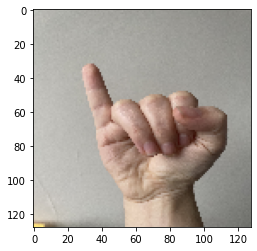

taa


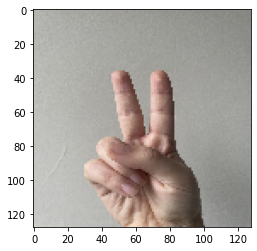

ghain


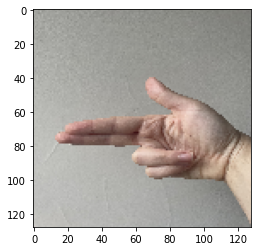

bb


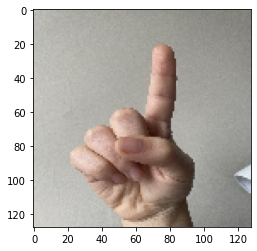

waw


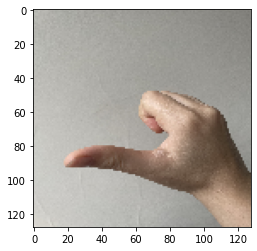

dhad


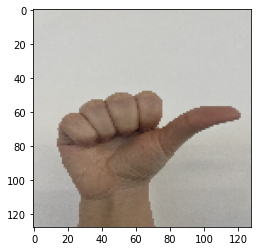

ya


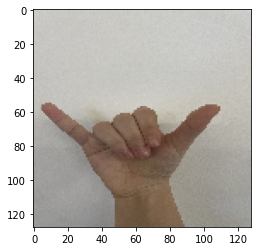

kaaf


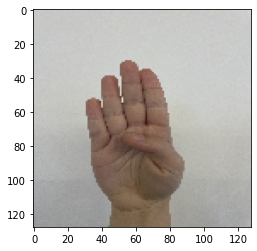

laam


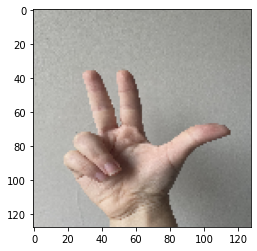

saad


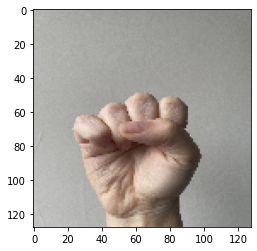

In [ ]:
from tensorflow.image import resize
file_name = os.listdir('/content/files/Arabic_Img_Pred/')
for file in file_name:
  img=mpimg.imread('/content/files/Arabic_Img_Pred/'+file)
  img = resize(img, (nx,ny))
  img = np.array(img)/255
  img = np.reshape(img,(1,nx,ny,3))
  print(class_name[np.argmax(model.predict(img))])
  plt.imshow(np.reshape(img,(nx,ny,3)))
  plt.show()


In [ ]:
W =[]
count = 1
resize_image = Sequential(layers.Resizing(64,64))
file_name = os.listdir('/content/files/Arabic_Img_Pred')
for value in file_name:
  if '.jpg' in value:
    img=mpimg.imread(f"/content/files/Arabic_Img_Pred/{value}")
    img = color.rgb2gray(img)*255
    #print(img.shape)
    test = np.array(img)[818:-190, ]
    #print(test.shape)
    final = rescale(test, 64/3024, anti_aliasing=True)/255
    # final = resize_image(test)/255
    #print(final.shape)
    if W == []:
      W = np.array(final)
      #print(W.shape)
      img_shape = np.prod(W.shape)
      #print(img_shape)
      W = np.reshape(W,(1,img_shape))
      print(W.shape)
    else:
      W = np.concatenate((W,np.reshape(np.array(final),(1,img_shape))),axis=0)


(1, 4096)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app


In [ ]:
W.shape

(10, 4096)

In [ ]:
stacked_img_W = np.stack((W,)*3, axis=-1)
stacked_img_W.shape

(10, 4096, 3)

In [ ]:
img_pred = stacked_img_W.reshape(-1,64,64,3)
img_pred.shape


(10, 64, 64, 3)

In [ ]:
transfer = model.predict(img_pred)

ValueError: ignored

In [ ]:
# from tensorflow.image import resize
# file_name = os.listdir('/content/drive/MyDrive/Arabic_Img_Pred')
# for value in file_name:
#   if '.jpg' in value:
#     img = mpimg.imread(value)
#     img = np.array(img)/255
    
#     img = resize(img, (nx,ny))
#     plt.imshow(np.array(img))
#     print(class_name[np.argmax(model.predict(np.reshape(img,(1,nx,ny,3))))])